<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/neural-processes/02-neural-processes-keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon Sep 30 05:13:17 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!git clone https://github.com/martin-fabbri/colab-notebooks

Cloning into 'colab-notebooks'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 356 (delta 112), reused 79 (delta 30), pack-reused 147
Receiving objects: 100% (356/356), 9.63 MiB | 24.29 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfe = tf.contrib.eager
tf.enable_eager_execution()

print('tf:', tf.__version__)
print('tfp:', tfp.__version__)

tf: 1.14.0
tfp: 0.7.0


### Neural Process for 1D functions

This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are defined by f(x) = a * sin(x - b) where a and b and randomly sampled.

#### Visualize Data

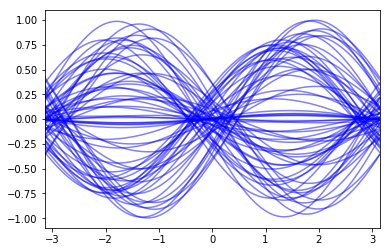

In [0]:
# Create dataset
dataset = SineData(amplitude_range=(-1., 1.),
                   shift_range=(-.5, .5),
                   num_samples=2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Build Neural Process

In [0]:
from neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior
We can visualize the prior (i.e. the output of the neural process without any context points) before training

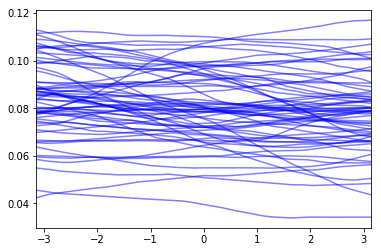

In [0]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Train Neural Process

In [0]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 2
num_context = 4
num_target = 4

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 7.640
iteration 400, loss 3.022
iteration 600, loss 8.835
iteration 800, loss 4.466
iteration 1000, loss 4.639
Epoch: 0, Avg_loss: 4.113195377297699
iteration 1200, loss -4.893
iteration 1400, loss 2.433
iteration 1600, loss -5.859
iteration 1800, loss -1.750
iteration 2000, loss 8.920
Epoch: 1, Avg_loss: 2.095598144952208
iteration 2200, loss 8.768
iteration 2400, loss -8.929
iteration 2600, loss -3.048
iteration 2800, loss 2.969
iteration 3000, loss 4.937
Epoch: 2, Avg_loss: 2.0471422040537
iteration 3200, loss 5.971
iteration 3400, loss -10.030
iteration 3600, loss 1.079
iteration 3800, loss -0.948
iteration 4000, loss 2.502
Epoch: 3, Avg_loss: 1.9852995169097558
iteration 4200, loss 7.452
iteration 4400, loss 2.250
iteration 4600, loss 7.942
iteration 4800, loss 4.781
iteration 5000, loss 4.104
Epoch: 4, Avg_loss: 1.869713378449902
iteration 5200, loss 5.878
iteration 5400, loss 0.044
iteration 5600, loss 4.945
iteration 5800, loss -2.115
iteration 6000, loss 2.

### Visualize samples from trained prior
The prior should now encode some information about the shapes of the functions.

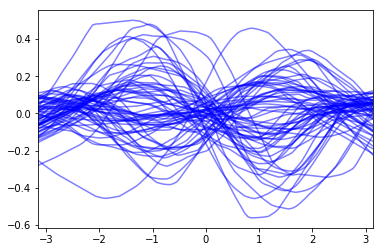

In [0]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-pi, pi)

### Visualize samples from posterior

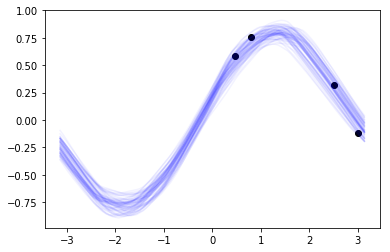

In [0]:

from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')